# Value Estimation -- quadrature vs uniform

In [114]:
import math
from importlib import reload

import gc
import matplotlib.pyplot as plt
import pickle
import numpy as np

from tqdm.notebook import tqdm

from adaptive_time import plot_utils
from adaptive_time import utils
from adaptive_time import run_lib
from adaptive_time.environments import cartpole2
from adaptive_time import value_est
from adaptive_time.value_est import approx_integrators

from pprint import pprint

approx_integrators = reload(approx_integrators)
run_lib = reload(run_lib)
cartpole2 = reload(cartpole2)
value_est = reload(value_est)
plot_utils = reload(plot_utils)
utils = reload(utils)

/Users/szepi1991/Code/adaptive_time/.venv/lib/python3.11/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment CartPole-OURS-v2 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


Make this notebook configurable so we can quickly generate plots for multiple variants.

In [2]:
utils.set_directory_in_project()

Changed working directory to /Users/szepi1991/Code/adaptive_time


'/Users/szepi1991/Code/adaptive_time'

In [3]:
# Execute the notebook with arguments; from
# https://stackoverflow.com/a/48414195

import sys,os,argparse
from IPython.display import HTML
CONFIG_FILE = '.tmp_config_ipynb'
if os.path.isfile(CONFIG_FILE):
    with open(CONFIG_FILE) as f:
        sys.argv = f.read().split()
else:
    sys.argv = ['test_args.py', '--discrete_reward', 'True']
    # sys.argv = ['test_args.py', 'input_file', '--int_param', '12']


def str2bool(v):
    """From: https://stackoverflow.com/a/43357954 ."""
    if isinstance(v, bool):
        return v
    if v.lower() in ('yes', 'true', 't', 'y', '1'):
        return True
    elif v.lower() in ('no', 'false', 'f', 'n', '0'):
        return False
    else:
        raise argparse.ArgumentTypeError('Boolean value expected.')


parser = argparse.ArgumentParser()
parser.add_argument(
    "--generate_new_data", type=str2bool, nargs='?', default=False,
    help="If true, generate new trajectory data, else load from file.")
parser.add_argument(
    "--save_new_data", type=str2bool, nargs='?', default=True,
    help="If true, save the newly generated data a file.")
parser.add_argument(
    "--grab_detailed_data", type=str2bool, nargs='?', default=False,
    help="If true, save not just the reward sequences but states, actions, etc.")


parser.add_argument(
    "--discrete_reward", type=str2bool, nargs='?', default=True,
    help="Use the step function reward.")
parser.add_argument(
    "--terminate_env", type=str2bool, nargs='?', default=False,
    help="Whether to terminate the environment when the pole falls.")


parser.add_argument(
    "--num_runs", type=int, default=30,
    help="The number of independent runs per method.")
parser.add_argument(
    "--sample_budget", type=int, default=1_000_000,
    help="The number of total samples accessible to all methods.")


# parser.add_argument("input_file",  help="Input image, directory, or npy.")
# parser.add_argument("--int_param", type=int, default=4, help="an optional integer parameter.")
args = parser.parse_args()

print(args.discrete_reward)


False


## Use goodish policy, generate data to process

Recall, we want:

1. The policy to stay up for ~10k steps, while we interact for 20k steps.
2. To generate trajectories from 100 different initial states.

We just need to store the fine grained rewards for each of these trajectories, all processing will happen on this after. 

In [48]:

GENERATE_NEW_DATA = args.generate_new_data
# GENERATE_NEW_DATA = False
GENERATE_NEW_DATA = True

SAVE_TRAJECTORIES = args.save_new_data
# SAVE_TRAJECTORIES = False
SAVE_TRAJECTORIES = True

SHOULD_TERMINATE = args.terminate_env
# SHOULD_TERMINATE = False
SHOULD_TERMINATE = True

discrete_reward = args.discrete_reward
# discrete_reward = False
discrete_reward = True


GRAB_DETAILED_DATA = args.grab_detailed_data
GRAB_DETAILED_DATA = False

NUM_RUNS = args.num_runs
SAMPLE_BUDGET = args.sample_budget

NUM_RUNS = 100
SAMPLE_BUDGET = 1_000_000

BUDGET_INTERP_STEP = 1_000


In [49]:

if discrete_reward:
    reward_type = "discrete"
else:
    reward_type = "continuous"


BASE_DIR = f"results/cartpole2/rew_{reward_type}_term{SHOULD_TERMINATE}"
traj_data_file = f"many_good_trajs.pkl"
procesed_data_file = f"processed_data.pkl"



In [54]:
utils.set_directory_in_project(BASE_DIR, create_dirs=True)  # Just to make the dir.
utils.set_directory_in_project()
traj_data_path = os.path.join(BASE_DIR, traj_data_file)

gc.collect()

if GENERATE_NEW_DATA:
    seed = 13
    dt_scaler = 200.
    new_dt = 0.02 / dt_scaler
    STEPS_MAX = 20_000
    STEPS_BREAK_FROM = 9_000

    NUM_TRAJS = 2
    # NUM_TRAJS = 20

    from adaptive_time import mc2
    import adaptive_time.utils
    import gymnasium as gym
    import random

    env = gym.make(
        'CartPole-OURS-v2',
        discrete_reward=discrete_reward,
        should_terminate=SHOULD_TERMINATE,
        step_time=new_dt)
    _NUM_ACTIONS = 2

    phi = run_lib.make_features()

    weights_good_policy = np.load("cartpole_weights_20240227-102913_ret92516.44719752521.npy")
    # weights_good_policy = np.load("cartpole_weights_20240227-102913_ret50756.37604280466.npy")

    def policy(state, num_step, weights, epsilon):
        if num_step >= STEPS_BREAK_FROM:
            # if random.random() < 0.95:  # spread of 60 at 100 trajs
            # if random.random() < 0.55:  # a nice spread
            return 0   # Alway push in one direction.

        if random.random() < epsilon:
            action = env.action_space.sample()
            return action

        # Otherwise calculate the best action.
        x = phi.get_fourier_feature(state)
        qs = np.zeros(_NUM_ACTIONS)
        for action in range(_NUM_ACTIONS):
            x_sa = mc2.phi_sa(x, action)
            qs[action] = np.inner(x_sa.flatten(), weights)
        # adaptive_time.utils.softmax(qs, 1)
        
        return adaptive_time.utils.argmax(qs)

    run_lib.reset_randomness(seed, env)

    def _random_start_state(num):
        rand = np.random.standard_normal((num, 4))
        # rand *= np.array([[0.01, 0.01, 0.005, 0.002]])
        rand *= np.array([[0.01, 0.01, 0.005, 0.002]])
        return rand

    start_states = _random_start_state(NUM_TRAJS)
    print("shape", start_states.shape)
    print("max", np.max(start_states, axis=0))

    total_rewards = []
    reward_sequences = []
    traj_lengths = []
    angles = []
    xs = []
    d_angles = []
    actions = []
    dxs = []
    for idx in tqdm(range(NUM_TRAJS)):
        start_state = tuple(start_states[idx])
        # Tuple[float, float, float, float]
        trajectory, early_term = value_est.generate_trajectory(
                env, start_state=start_state,
                policy=lambda st, sn: policy(st, sn, weights_good_policy, 0.0),
                # policy=policy,
                termination_prob=0.0, max_steps=STEPS_MAX)

        traj_lengths.append(len(trajectory))
        rewards = [r for _, _, r, _ in trajectory]
        if GRAB_DETAILED_DATA:
            actions.append([a for _, a, _, _ in trajectory])
            xs.append([s[0] for s, _, _, _ in trajectory])
            angles.append([s[2] for s, _, _, _ in trajectory])
            d_angles.append([s[3] for s, _, _, _ in trajectory])
            dxs.append([s[1] for s, _, _, _ in trajectory])
        reward_sequences.append(rewards)
        total_rewards.append(sum(rewards))

    total_rewards = np.array(total_rewards)
    # Reward sequences may be different lengths in the terminating
    # case, so we can't make a 2D array.
    if not SHOULD_TERMINATE:
        reward_sequences = np.array(reward_sequences)
        traj_lengths = np.array(traj_lengths)
        angles = np.array(angles)
        xs = np.array(xs)
        d_angles = np.array(d_angles)
        actions = np.array(actions)
        dxs = np.array(dxs)

    if SAVE_TRAJECTORIES:
        if GRAB_DETAILED_DATA:
            details = (angles, xs, d_angles, actions, dxs)
        else:
            details = None
        all_traj_data = (
            total_rewards, reward_sequences, traj_lengths,
            details
        )
        with open(traj_data_path, "wb") as f:
            pickle.dump(all_traj_data, f)
        print("Saved data to", traj_data_path)

    print(env.tau)

else:
    with open(traj_data_path, "rb") as f:
        all_traj_data = pickle.load(f)
    total_rewards, reward_sequences, traj_lengths = all_traj_data[:3]
    if GRAB_DETAILED_DATA:
        rest = all_traj_data[3:]
        if len(rest) == 1:
            angles, xs, d_angles, actions, dxs = rest[0]
        else:
            angles, xs, d_angles, actions, dxs = rest

    print("Loaded data from", traj_data_path)

del all_traj_data   # Clear up memory.

print("total_rewards for each traj:", total_rewards)
if hasattr(reward_sequences, "shape"):
    print("all rewards shape if array:", reward_sequences.shape)
num_trajs = len(total_rewards)

Changed working directory to /Users/szepi1991/Code/adaptive_time/results/cartpole2/rew_discrete_termTrue
Changed working directory to /Users/szepi1991/Code/adaptive_time
shape (2, 4)
max [0.01345102 0.00753766 0.00675094 0.00172242]


  0%|          | 0/2 [00:00<?, ?it/s]

Saved data to results/cartpole2/rew_discrete_termTrue/many_good_trajs.pkl
0.0001
total_rewards for each traj: [10723. 10708.]


In [55]:
utils.set_directory_in_project(BASE_DIR, create_dirs=True)
gc.collect()


Changed working directory to /Users/szepi1991/Code/adaptive_time/results/cartpole2/rew_discrete_termTrue


26

### Test trajectories

In [145]:
desired_length1 = 10722
desired_length2 = 10723
total_rewards = np.array([desired_length1, desired_length2])
reward_sequences = np.array([[1.0] * desired_length1 + [1.0] * desired_length2])
traj_lengths = np.array([desired_length1, desired_length2])



ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

### Analyze trajectories

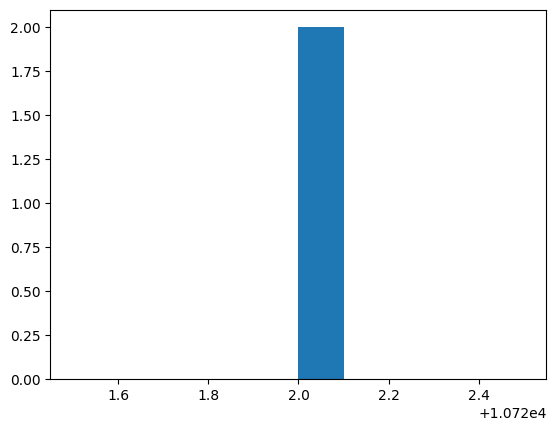

In [ ]:
plt.hist(total_rewards)
plt.savefig('reward_total_distr.png')

10722


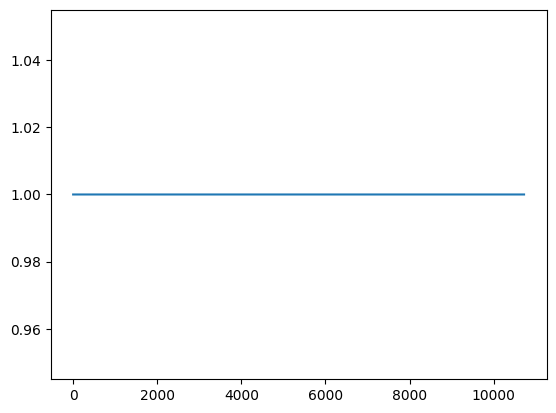

In [ ]:
traj_idx = 0
print(total_rewards[traj_idx])
plt.plot(reward_sequences[traj_idx])
plt.savefig('reward_sample_curve.png')

### Deep Traj Analysis

In [ ]:
# fig, ax = plt.subplots(5, 1, figsize=(10, 15))

# # Actions -- bin them:
# binsize = 100
# binned_actions = []
# for i in range(0, len(actions[traj_idx]), binsize):
#     binned_actions.append(np.mean(actions[traj_idx][i:i+binsize]))
# axs = np.arange(0, len(actions[traj_idx]), step=binsize)

# ax[0].plot(axs, binned_actions, linestyle="none", marker="o")
# ax[0].set_title("Actions")

# # ax[0].plot(np.abs(actions[traj_idx]), linestyle="none", marker="o")
# ax[1].plot(np.abs(angles[traj_idx]))
# ax[1].set_title("Angles")

# ax[2].plot(d_angles[traj_idx])
# ax[2].set_title("Angular velocity")

# ax[3].plot(xs[traj_idx])
# ax[3].set_title("X position")

# ax[4].plot(dxs[traj_idx])
# ax[4].set_title("Velocity")

# # for a in ax:
# #     a.set_xlim(1000, 1500)


## Data setup 2: the weights across initial states


In [ ]:
seed = 43
run_lib.reset_randomness(seed, env=None)

weights = np.ones((num_trajs,)) / num_trajs
# weights = np.random.random((num_trajs,))
# weights /= np.sum(weights)

print("weights:", weights)
print("sum:", np.sum(weights))

weights: [0.5 0.5]
sum: 1.0


## Learning

Constants

In [ ]:
print("num_runs:", NUM_RUNS)
print("sample_budget:", SAMPLE_BUDGET)

num_runs: 100
sample_budget: 1000000


### Ground truth value

In [ ]:
true_value = total_rewards @ weights
print("true value:", true_value)

true value: 10722.0


### Learn from samples; with diff samplers

In [ ]:
unif_sampler_params = np.power(2, np.arange(0, 11, 2))
quad_sampler_params = np.concatenate(
    (np.array([0]), np.power(2, np.arange(-3.0, 10, 2))), axis=0
)

print('unif_sampler_params:', unif_sampler_params)
print('quad_sampler_params:', quad_sampler_params)


unif_sampler_params: [   1    4   16   64  256 1024]
quad_sampler_params: [0.00e+00 1.25e-01 5.00e-01 2.00e+00 8.00e+00 3.20e+01 1.28e+02 5.12e+02]


In [ ]:
samplers_tried = {
    f'q{p}': approx_integrators.AdaptiveQuadratureIntegrator(tolerance=p)
    for p in quad_sampler_params
}
samplers_tried.update({
    f'u{p}': approx_integrators.UniformlySpacedIntegrator(p)
    for p in unif_sampler_params
})


In [ ]:
def name_to_param(name):
    num = float(name[1:])
    if name[0] == 'q':
        return num
    else:
        return int(num)

def name_to_type(name):
    return name[0]

def param_to_name(sampler_char, param):
    return f"{sampler_char}{param}"

Since everything other than the start state is deterministic, we can just calculate the approximate integrals for each trajectory with each integrator and store these.

In [ ]:
approx_integrals = {}
num_pivots = {}

for sampler_name, sampler in tqdm(samplers_tried.items()):
    print("sampler_name:", sampler_name)
    approx_integrals[sampler_name] = []
    num_pivots[sampler_name] = []
    for idx, reward_seq in enumerate(reward_sequences):
        integral, all_pivots = sampler.integrate(reward_seq)
        approx_integrals[sampler_name].append(integral)
        num_pivots[sampler_name].append(len(all_pivots))
    approx_integrals[sampler_name] = np.array(approx_integrals[sampler_name])
    num_pivots[sampler_name] = np.array(num_pivots[sampler_name])



  0%|          | 0/14 [00:00<?, ?it/s]

sampler_name: q0.0
sampler_name: q0.125
sampler_name: q0.5
sampler_name: q2.0
sampler_name: q8.0
sampler_name: q32.0
sampler_name: q128.0
sampler_name: q512.0
sampler_name: u1
sampler_name: u4
sampler_name: u16
sampler_name: u64
sampler_name: u256
sampler_name: u1024


In [ ]:
traj_id = 0

print("Sample data for trajectory 0:")
print("* True return:", total_rewards[traj_id])
print("* Approx integrals:")
{k: v[traj_id] for k, v in approx_integrals.items()}


Sample data for trajectory 0:
* True return: 10722
* Approx integrals:


{'q0.0': 10722.0,
 'q0.125': 10722.0,
 'q0.5': 10722.0,
 'q2.0': 10722.0,
 'q8.0': 10722.0,
 'q32.0': 10722.0,
 'q128.0': 10722.0,
 'q512.0': 10722.0,
 'u1': 10722.0,
 'u4': 10722.0,
 'u16': 10722.0,
 'u64': 10722.0,
 'u256': 10722.0,
 'u1024': 10722.0}

In [ ]:
traj_id = 0

{k: v[traj_id] for k, v in num_pivots.items()}


{'q0.0': 3,
 'q0.125': 3,
 'q0.5': 3,
 'q2.0': 3,
 'q8.0': 3,
 'q32.0': 3,
 'q128.0': 3,
 'q512.0': 3,
 'u1': 10722,
 'u4': 2682,
 'u16': 672,
 'u64': 169,
 'u256': 43,
 'u1024': 12}

Now we just keep sampling the start state and integrate accordingly.

In [ ]:
gc.collect()

46839

In [ ]:

seed = 43

samplers_to_learn_with = samplers_tried
# samplers_to_learn_with = {
#     'u1024': samplers_tried['u1024'],
# }

data = value_est.simulate_learning(
        seed, samplers_to_learn_with, SAMPLE_BUDGET, num_runs=NUM_RUNS,
        start_state_weights=weights,
        approx_integrals=approx_integrals, num_pivots=num_pivots,
        tqdm=tqdm)


gc.collect()
# with open(procesed_data_file, "wb") as f:
#     pickle.dump(data, f)


  0%|          | 0/14 [00:00<?, ?it/s]

sampler_name: q0.0


  0%|          | 0/100 [00:00<?, ?it/s]

sampler_name: q0.125


  0%|          | 0/100 [00:00<?, ?it/s]

sampler_name: q0.5


  0%|          | 0/100 [00:00<?, ?it/s]

sampler_name: q2.0


  0%|          | 0/100 [00:00<?, ?it/s]

sampler_name: q8.0


  0%|          | 0/100 [00:00<?, ?it/s]

sampler_name: q32.0


  0%|          | 0/100 [00:00<?, ?it/s]

sampler_name: q128.0


  0%|          | 0/100 [00:00<?, ?it/s]

sampler_name: q512.0


  0%|          | 0/100 [00:00<?, ?it/s]

sampler_name: u1


  0%|          | 0/100 [00:00<?, ?it/s]

sampler_name: u4


  0%|          | 0/100 [00:00<?, ?it/s]

sampler_name: u16


  0%|          | 0/100 [00:00<?, ?it/s]

sampler_name: u64


  0%|          | 0/100 [00:00<?, ?it/s]

sampler_name: u256


  0%|          | 0/100 [00:00<?, ?it/s]

sampler_name: u1024


  0%|          | 0/100 [00:00<?, ?it/s]

152

In [ ]:
list(data.values())[0][0].keys()

dict_keys(['running_v_estimate', 'total_pivots'])

In [ ]:
# # Verify final means.
# for sampler_name, all_runs_data in data.items():
#     for run_idx, run_data in enumerate(all_runs_data):
#         mean_of_indiv = np.mean(run_data["values_of_trajs"])
#         mean_updated = run_data["running_v_estimate"][-1]
#         if run_idx == 0:
#             print("mean_total:", mean_of_indiv, "mean_updated:", mean_updated)
#         if abs(mean_of_indiv - mean_updated) > 0.01:
#             assert False, (
#                 f"Means don't match for {sampler_name}, run {run_idx}: "
#                 f"{mean_of_indiv} vs {mean_updated}")


In [ ]:
gc.collect()

_values_data = plot_utils.process_across_runs(
        data, "total_pivots", "running_v_estimate", right=np.nan, interp_step=BUDGET_INTERP_STEP, tqdm=tqdm)

gc.collect()

_means = {
    k: np.abs(val - true_value)
    for k, val in _values_data.means.items()
}
error_data = _values_data._replace(means=_means)

error_y_label = "$|\hat{V}(S_0) - v_\pi(S_0)|$"

interpolating


  0%|          | 0/14 [00:00<?, ?it/s]

finding means and stderrs


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/szepi1991/Code/adaptive_time/code/adaptive_time/plot_utils.py:70: RuntimeWarning: Mean of empty slice
  
/Users/szepi1991/Code/adaptive_time/.venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [ ]:
_values_data.means

{'q0.0': array([10722., 10722., 10722., ...,    nan,    nan,    nan]),
 'q0.125': array([10722., 10722., 10722., ...,    nan,    nan,    nan]),
 'q0.5': array([10722., 10722., 10722., ...,    nan,    nan,    nan]),
 'q2.0': array([10722., 10722., 10722., ...,    nan,    nan,    nan]),
 'q8.0': array([10722., 10722., 10722., ...,    nan,    nan,    nan]),
 'q32.0': array([10722., 10722., 10722., ...,    nan,    nan,    nan]),
 'q128.0': array([10722., 10722., 10722., ...,    nan,    nan,    nan]),
 'q512.0': array([10722., 10722., 10722., ...,    nan,    nan,    nan]),
 'u1': array([10722., 10722., 10722., ..., 10722., 10722., 10722.]),
 'u4': array([10722., 10722., 10722., ...,    nan,    nan,    nan]),
 'u16': array([10722., 10722., 10722., ...,    nan,    nan,    nan]),
 'u64': array([10722., 10722., 10722., ...,    nan,    nan,    nan]),
 'u256': array([10722., 10722., 10722., ...,    nan,    nan,    nan]),
 'u1024': array([10722., 10722., 10722., ...,    nan,    nan,    nan])}

In [ ]:
setting_name = "step reward" if discrete_reward else "smooth reward"
setting_name += ", "
setting_name += "term if falls" if SHOULD_TERMINATE else "(20k steps)"
print(setting_name)

title = f"setting: {setting_name}"

step reward, term if falls


## Plots: Error vs Samples [commented out]

In [ ]:
plot_space = SAMPLE_BUDGET / 20.

#### Uniforms

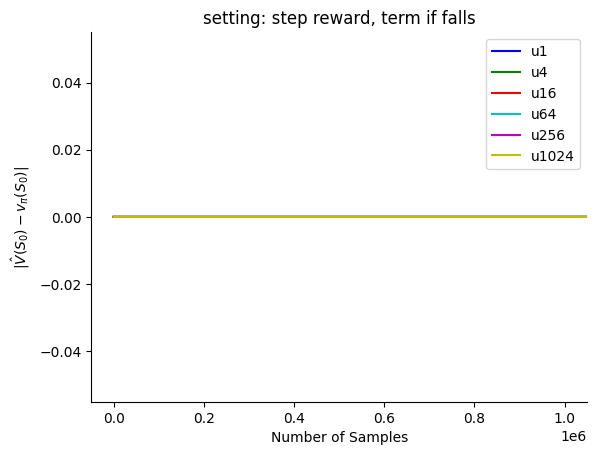

In [ ]:
ax = plot_utils.default_plot_mean_from_proc_data(
    error_data, "Number of Samples", error_y_label,
    title=title, show=False, key_filter=lambda x: "u" in x,
    add_stderr=True)

ax.set_xlim(-plot_space, SAMPLE_BUDGET + plot_space)
plt.savefig('unif_lin.png')



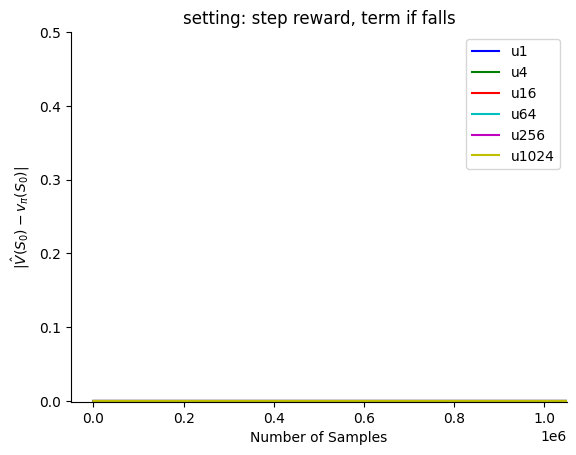

In [ ]:
ax = plot_utils.default_plot_mean_from_proc_data(
    error_data, "Number of Samples", error_y_label,
    title=title, show=False, key_filter=lambda x: "u" in x,
    add_stderr=True)

ax.set_xlim(-plot_space, SAMPLE_BUDGET + plot_space)
ax.set_ylim(-0.001, 0.5)

plt.savefig('unif_lin_zoom.png')



/var/folders/xt/69nn93l959l31g_3b686nmsr0000gn/T/ipykernel_99752/1463412043.py:6: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')
/var/folders/xt/69nn93l959l31g_3b686nmsr0000gn/T/ipykernel_99752/1463412043.py:9: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(-plot_space, SAMPLE_BUDGET + plot_space)


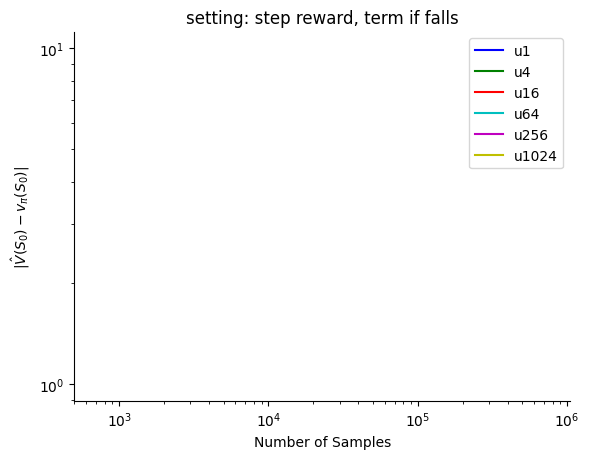

In [ ]:
ax = plot_utils.default_plot_mean_from_proc_data(
    error_data, "Number of Samples", error_y_label,
    title=title, show=False, key_filter=lambda x: "u" in x,
    add_stderr=True)

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlim(-plot_space, SAMPLE_BUDGET + plot_space)

plt.savefig('unif_loglog.png')



In [ ]:
# ax = plot_utils.default_plot_mean_from_proc_data(
#     error_data, "Number of Samples", error_y_label,
#     title=title, show=False, key_filter=lambda x: "u" in x,
#     add_stderr=True)

# ax.set_yscale('log')
# # ax.set_xscale('log')
# ax.set_xlim(-plot_space, SAMPLE_BUDGET + plot_space)

# plt.savefig('unif_ylog.png')



In [ ]:

# ax = plot_utils.default_plot_mean_from_proc_data(
#     error_data, "Number of Samples", error_y_label,
#     title=title, show=False, key_filter=lambda x: "q" in x,
#     add_stderr=True)

# ax.set_ylim(-1, 15)
# # ax.set_yscale('log')
# ax.set_xlim(-plot_space, SAMPLE_BUDGET + plot_space)


# plt.savefig('quad_lin_zoom.png')

# plt.show()



In [ ]:

# ax = plot_utils.default_plot_mean_from_proc_data(
#     error_data, "Number of Samples", error_y_label,
#     title=title, show=False, key_filter=lambda x: "q" in x,
#     add_stderr=True)

# # ax.set_ylim(-2, 15)
# ax.set_yscale('log')
# ax.set_xlim(-plot_space, SAMPLE_BUDGET + plot_space)


# plt.savefig('quad_ylog.png')

# plt.show()



/var/folders/xt/69nn93l959l31g_3b686nmsr0000gn/T/ipykernel_99752/3271312997.py:6: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')


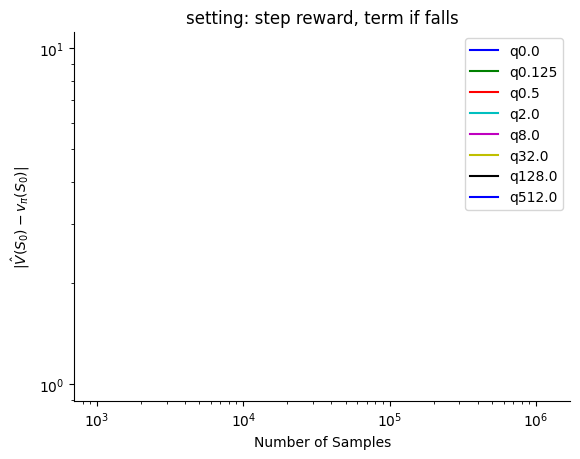

In [ ]:

ax = plot_utils.default_plot_mean_from_proc_data(
    error_data, "Number of Samples", error_y_label,
    title=title, show=False, key_filter=lambda x: "q" in x,
    add_stderr=True)

ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_xlim(-plot_space, SAMPLE_BUDGET + plot_space)

plt.savefig('quad_loglog.png')

plt.show()



In [ ]:
# good = ["u1", "u50", "u500", "q0", "q1", "q100"]

# ax = plot_utils.default_plot_mean_from_proc_data(
#     error_data, "Number of Samples", error_y_label,
#     title=title, show=False, key_filter=lambda x: x in good,
#     add_stderr=True)

# # ax.set_ylim(-2, 40)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlim(-plot_space, SAMPLE_BUDGET + plot_space)


# plt.savefig('select_loglog.png')

# plt.show()



## Error vs Param (Tolerance/Interval) Plots

In [ ]:
assert False

AssertionError: 

In [ ]:
error_data.means.keys()

dict_keys(['q0.0', 'q0.125', 'q0.5', 'q2.0', 'q8.0', 'q32.0', 'q128.0', 'q512.0', 'u1', 'u4', 'u16', 'u64', 'u256', 'u1024'])


Method: uniform


  0%|          | 0/4 [00:00<?, ?it/s]


Budget:  1000
xs [1, 4, 16, 64, 256, 1024]
y_means: [0.18       0.22       0.88325421 0.1730971  0.38376752 0.06792934]
y_stderrs: [1.31086079 1.18835853 0.92388678 0.49523179 0.2794966  0.11905897]

Budget:  10000
xs [1, 4, 16, 64, 256, 1024]
y_means: [0.18       1.13354049 0.39923393 0.06596277 0.06358109 0.01332044]
y_stderrs: [1.31086079 0.65865304 0.28154451 0.15987929 0.07938586 0.04496184]

Budget:  100000
xs [1, 4, 16, 64, 256, 1024]
y_means: [0.40152358 0.1692885  0.16684964 0.03551327 0.01893035 0.0117664 ]
y_stderrs: [0.44297972 0.18589826 0.10845457 0.05037754 0.02404123 0.01134396]

Budget:  1000000
xs [1, 4, 16, 64, 256, 1024]
y_means: [0.21298698 0.12000248 0.06896397 0.00501472 0.00646616 0.0020374 ]
y_stderrs: [0.13071169 0.05872932 0.03252049 0.01555451 0.0074991  0.0042287 ]

Method: quadrature


  0%|          | 0/4 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Budget:  1000
xs [0.0, 0.125, 0.5, 2.0, 8.0, 32.0, 128.0, 512.0]
y_means: [0.0490851  0.03831068 0.09795952 0.0531025  0.06262208 0.00746081
 0.05963158 0.0992179 ]
y_stderrs: [0.07240773 0.07132644 0.05997242 0.06777608 0.06071153 0.06679261
 0.07403673 0.0604116 ]

Budget:  10000
xs [0.0, 0.125, 0.5, 2.0, 8.0, 32.0, 128.0, 512.0]
y_means: [0.00488299 0.00525297 0.028792   0.02652099 0.05233903 0.01653197
 0.018245   0.01704298]
y_stderrs: [0.01914987 0.02051932 0.02054567 0.02160251 0.01985077 0.02227956
 0.02080877 0.01856587]

Budget:  100000
xs [0.0, 0.125, 0.5, 2.0, 8.0, 32.0, 128.0, 512.0]
y_means: [0.0018569 0.0098289 0.002266  0.0078539 0.0004813 0.0048266 0.0083505
 0.0014367]
y_stderrs: [0.00650108 0.00672801 0.00641264 0.00635447 0.00660173 0.00685755
 0.00747021 0.00637717]

Budget:  1000000
xs [0.0, 0.125, 0.5, 2.0, 8.0, 32.0, 128.0, 512.0]
y_means: [0.00133015 0.00047616 0.00205226 0.00061714 0.00107873 0.00147522
 0.00153765 0.00088651]
y_stderrs: [0.00215981 0.0022257

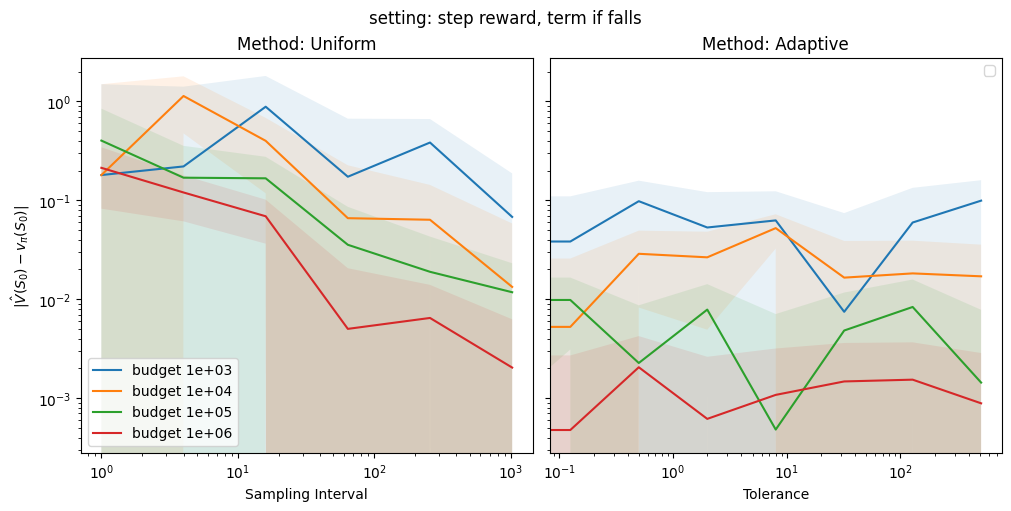

In [ ]:

# These must be multiples of BUDGET_INTERP_STEP (usually 1000).
budgets_to_check = np.power(10, np.arange(3, 7, 1))
if SAMPLE_BUDGET >= 2_000_000:
    budgets_to_check *= 2


# budgets_to_check = np.power(10, np.arange(2, 7, 1))

# ax = plot_utils.default_plot_mean_from_proc_data(
#     error_data, "Number of Samples", error_y_label,
#     title=title, show=False, key_filter=lambda x: x in good,
#     add_stderr=True)

fig, axes = plt.subplots(
    nrows=1, ncols=2, figsize=(10, 5), layout="constrained", sharey=True)

# axes[0] will get the uniform results, axes[1] the quadrature results.

# Gather the data for the points on the x-axis.
all_methods = error_data.means.keys()
unif_methods = {
    k: name_to_param(k) for k in all_methods if name_to_type(k) == "u"}
quad_methods = {
    k: name_to_param(k) for k in all_methods if name_to_type(k) == "q"}

unif_xs = sorted(unif_methods.values())
quad_xs = sorted(quad_methods.values())

for ax_idx, ax, xs, method_char in zip(range(2), axes, (unif_xs, quad_xs), ("u", "q")):
    print()
    print("Method:", "uniform" if method_char == "u" else "quadrature")
    for budget_for_curve in tqdm(budgets_to_check):
        print()
        print("Budget: ", budget_for_curve)
        budget_idx = int(budget_for_curve / BUDGET_INTERP_STEP)
        y_means = []
        y_stderrs = []
        try:
            for x in xs:
                y_means.append(error_data.means[param_to_name(method_char, x)][budget_idx])
                y_stderrs.append(error_data.stderrs[param_to_name(method_char, x)][budget_idx])
                # y_means.append(np.nanmean(env_result[x][:, budget_idx]))
                # y_stderrs.append(np.nanstd(env_result[x][:, budget_idx]) / np.sqrt(num_seeds))
            # y_means = np.log2(np.array(y_means))
            # y_stderrs = np.log2(np.array(y_stderrs))
                
            y_means = np.array(y_means)
            y_stderrs = np.array(y_stderrs)

            ax.plot(
                xs,
                y_means,
                label="budget {:.0e}".format(budget_for_curve) if ax_idx == 0 else ""
            )
            ax.fill_between(
                xs,
                (y_means - y_stderrs),
                (y_means + y_stderrs),
                alpha=0.1
            )

            print("xs", xs)
            print("y_means:", y_means)
            print("y_stderrs:", y_stderrs)
        except IndexError:
            pass

    if method_char == "u":
        ax.set_ylabel(error_y_label)
        ax.set_xlabel("Sampling Interval")
        ax.set_title("Method: Uniform")
    else:
        ax.set_xlabel("Tolerance")
        ax.set_title("Method: Adaptive")

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()

fig.suptitle(title)
plt.legend()

plt.savefig('u_shaped.png')

# def name_to_param(name):
#     return int(name[1:])

# def name_to_type(name):
#     return name[0]

# def param_to_name(param, sampler_char):
#     return f"{sampler_char}{param}"


In [ ]:


# if prefix == "uniform":
#     fig, axes = plt.subplots(nrows=len(est_results) // ncols, ncols=ncols, figsize=(15, 8), layout="constrained")

#     print(s_to_plot)
#     sorted_spacing = sorted(int(key[1:]) for key in list(s_to_plot))
#     sorted_keys = ["u{}".format(item) for item in sorted_spacing]
#     # budgets_to_check = 1e5 * np.arange(1, 10, 2)


#     budgets_to_check = budgets_to_check_per_env[env_name]
#     for budget_to_check in tqdm(budgets_to_check):
#         idx = int(budget_to_check)
#         y_means = []
#         y_stderrs = []
#         for s in sorted_keys:
#             y_means.append(np.nanmean(env_result[s][:, idx]))
#             y_stderrs.append(np.nanstd(env_result[s][:, idx]) / np.sqrt(num_seeds))
#         # y_means = np.log2(np.array(y_means))
#         # y_stderrs = np.log2(np.array(y_stderrs))
            
#         y_means = np.array(y_means)
#         y_stderrs = np.array(y_stderrs)

#         ax.plot(
#             sorted_spacing,
#             y_means,
#             label="{:.0e}".format(idx) if env_i == 0 else ""
#         )
#         ax.fill_between(
#             sorted_spacing,
#             (y_means - y_stderrs),
#             (y_means + y_stderrs),
#             alpha=0.1
#         )
#         ax.set_title("Env: {}".format(env_name))

#     fig.supylabel("Error in value estimate")
#     fig.supxlabel("Uniform Discretization")
#     fig.legend()
#     plt.show()




# Testing Random Things

In [ ]:
(math.pi + 3.5) % (2*math.pi) - math.pi

-2.7831853071795862